In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns

import sklearn.metrics
from sklearn.cross_validation import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [3]:
redshift_file = np.load("data/redshift_mags.npz")
mags, redshifts = redshift_file['mags'][::100], redshift_file['z'][::100]

In [4]:
stacked = np.hstack((mags, redshifts.reshape(redshifts.shape[0], 1)))
col_names = ['u', 'g', 'r', 'i', 'z', 'redshift']
redshift_df = pd.DataFrame(stacked, columns=col_names)
print redshift_df

              u          g          r          i          z  redshift
0     17.150417  15.497092  14.674012  14.234288  13.907544  0.021222
1     20.891638  18.847141  17.699486  17.199553  16.776148  0.125820
2     19.015692  17.501614  16.702612  16.310234  16.004833  0.083186
3     19.261532  18.121223  17.545296  17.228493  17.055941  0.025183
4     19.761936  18.341272  17.586456  17.178825  16.867146  0.082105
5     17.973469  16.164104  15.348441  14.945671  14.608737  0.037611
6     18.638084  16.765795  15.823206  15.348632  14.965608  0.094902
7     19.089142  17.777235  17.347298  17.089390  16.987057  0.033712
8     19.072569  17.670670  16.918528  16.515005  16.247639  0.087895
9     19.112446  17.114983  16.110388  15.656266  15.271649  0.110249
10    20.496025  18.589727  17.414009  16.925301  16.514797  0.160985
11    19.980770  18.527195  17.616690  17.218946  16.882959  0.152071
12    19.261761  17.646940  17.068640  16.685247  16.650362  0.109966
13    19.514725  18.

/Users/nobleWkennamer/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


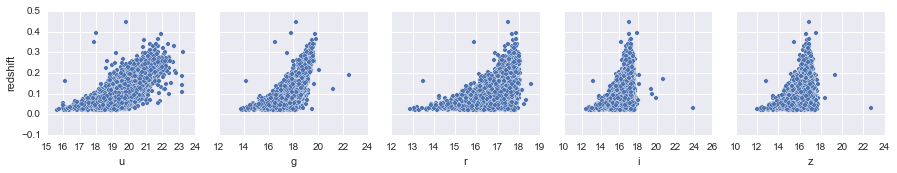

In [5]:
sns.pairplot(redshift_df, y_vars=col_names[-1], x_vars=col_names[:-1], palette='husl')

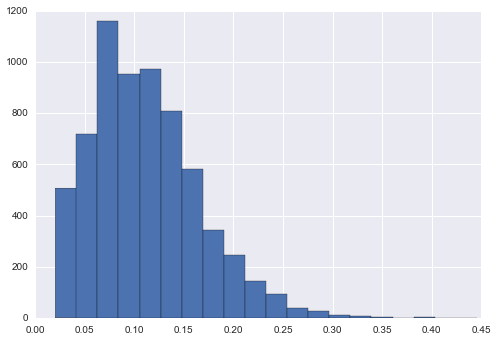

In [6]:
n, bins, patches = plt.hist(redshift_df['redshift'], bins=20)

In [7]:
colors_train, colors_test, redshift_train, redshift_test = train_test_split(mags, redshifts, 
                                                                            test_size=0.25, random_state=13)

##Compute Results

In [8]:
def compute_results(y_true, y_pred):
    
    explained_var = sklearn.metrics.explained_variance_score(y_true, y_pred)
    mean_abs_error = sklearn.metrics.mean_absolute_error(y_true, y_pred)
    r2_score = sklearn.metrics.r2_score(y_true, y_pred)
    mean_squared_error = sklearn.metrics.mean_squared_error(y_true, y_pred)
    
    results = {'scores': [explained_var, mean_abs_error, r2_score, mean_squared_error],
               'pred': y_pred}
    return results

##Models

In [9]:
def decision_tree_regression(x_train, y_train, x_test, y_test):
    d_tree = DecisionTreeRegressor(max_depth=8)
    d_tree.fit(x_train, y_train)
    predicted = d_tree.predict(x_test)
    return compute_results(y_test, predicted)

In [10]:
def random_forest_regression(x_train, y_train, x_test, y_test):
    rf = RandomForestRegressor(n_estimators=10,max_depth=8)
    rf.fit(x_train, y_train)
    predicted = rf.predict(x_test)
    return compute_results(y_test, predicted)

In [11]:
def linear_regression(x_train, y_train, x_test, y_test):
    lr = LinearRegression(fit_intercept=True)
    lr.fit(x_train, y_train)
    predicted = lr.predict(x_test)
    return compute_results(y_test, predicted)

In [12]:
def plot_true_vs_pred(y_true, results, mags, band, band_name):
    colors_pl = matplotlib.cm.rainbow(np.linspace(0, 1, len(results)+1))
    
    plt.scatter(mags[:, band], y_true, label='True', color=colors_pl[0])
    i=1
    for model, results_dict in results.items():
        plt.scatter(mags[:, band], results_dict['pred'], label=model, color=colors_pl[i])
        i+=1
    
    plt.title(band_name + ' Magnitude vs. Redshift')
    plt.xlabel(band_name + ' Magnitue')
    plt.ylabel('Redshift')
    plt.legend(loc="lower left")

In [13]:
def run_models(x_train, y_train, x_test, y_test):
    results = dict()
    
    #RUN Models
    
    #Linear Regression
    lr_results = linear_regression(x_train, y_train, x_test, y_test)
    results['LR'] = lr_results
    
    #Decision Tree
    d_tree_results = decision_tree_regression(x_train, y_train, x_test, y_test)
    results['D Tree'] = d_tree_results
    
    
    #Random Forest
    rf_results = decision_tree_regression(x_train, y_train, x_test, y_test)
    results['RF'] = rf_results
    
    # Print reports
    scores = []
    models = []
    for model, results_dict in results.items():
        models.append(model)
        scores.append(results_dict['scores'])
    
    column_names = ['Explained Variance', 'Mean Absolute Error', 'R2 Score', 'Mean Squared Error']
    score_df = pd.DataFrame(scores, columns=column_names, index=models)
    print score_df
    
    # Plot Predicted
    plot_true_vs_pred(y_test, results, x_test, 0, 'u')
    plt.figure()
    plot_true_vs_pred(y_test, results, x_test, 1, 'g')
    plt.figure()
    plot_true_vs_pred(y_test, results, x_test, 2, 'r')
    plt.figure()
    plot_true_vs_pred(y_test, results, x_test, 3, 'i')
    plt.figure()
    plot_true_vs_pred(y_test, results, x_test, 4, 'z')
    
    

        Explained Variance  Mean Absolute Error  R2 Score  Mean Squared Error
D Tree            0.655634             0.023714  0.655630            0.001046
LR                0.655654             0.022644  0.655337            0.001047
RF                0.655079             0.023740  0.655076            0.001048


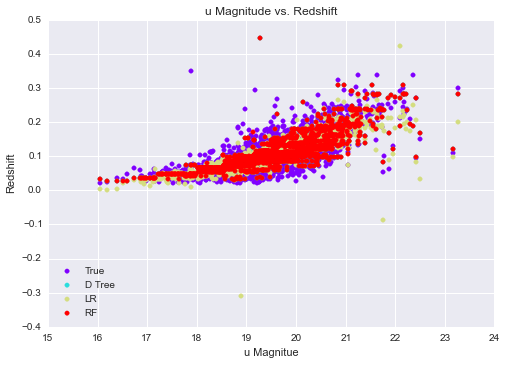

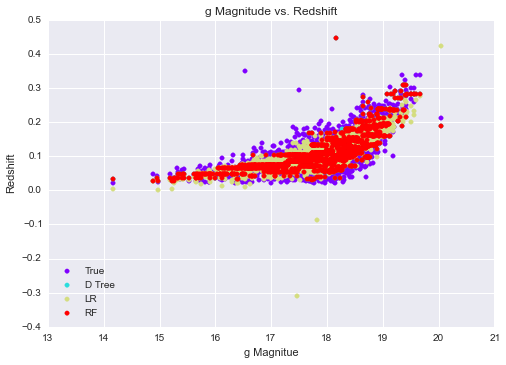

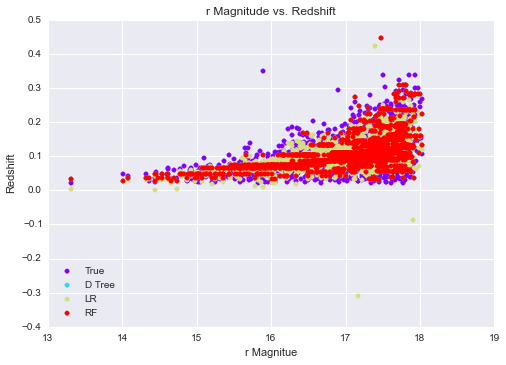

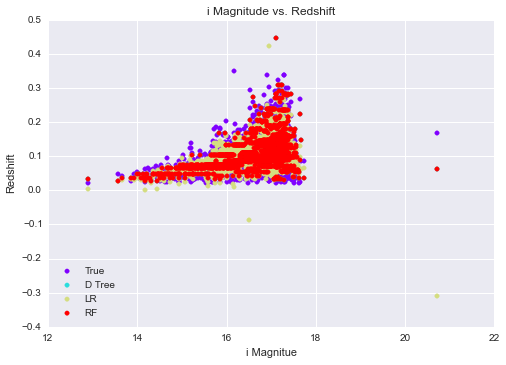

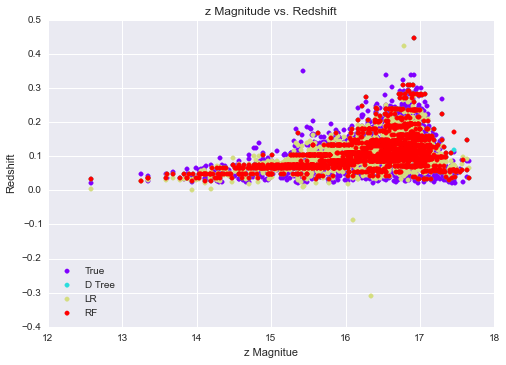

In [14]:
run_models(colors_train, redshift_train, colors_test, redshift_test)